In [758]:
import numpy as np
from scipy import signal
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from tqdm.notebook import tqdm
import datetime as dt
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae


style.use("seaborn-white")
plt.rc("figure", figsize=(20, 20))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../london_merged.csv", parse_dates=["timestamp"], index_col="timestamp")
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [716]:
chosen_vars = [
    df.cnt.diff(365*24).diff(1).diff(24).dropna(),
    df.t1.diff(365*24).diff(1).diff(24).dropna(),
    df.hum.diff(365*24).diff(1).diff(24).dropna(),
    df.wind_speed.diff(1).diff(24).dropna().loc[dt.datetime(2016, 1, 6, 22):]
]
targets = chosen_vars[:2]

In [701]:
def plot_series(series, ax=plt):
    result = smt.stattools.adfuller(series)
    ax.plot(series, label=series.name)
    ax.plot(series.rolling(24*5).mean(), label='mean')
    ax.legend()
    ax.title.set_text(f"Augmented Dickey-Fuller test p-value for {series.name}: {result[1]}")

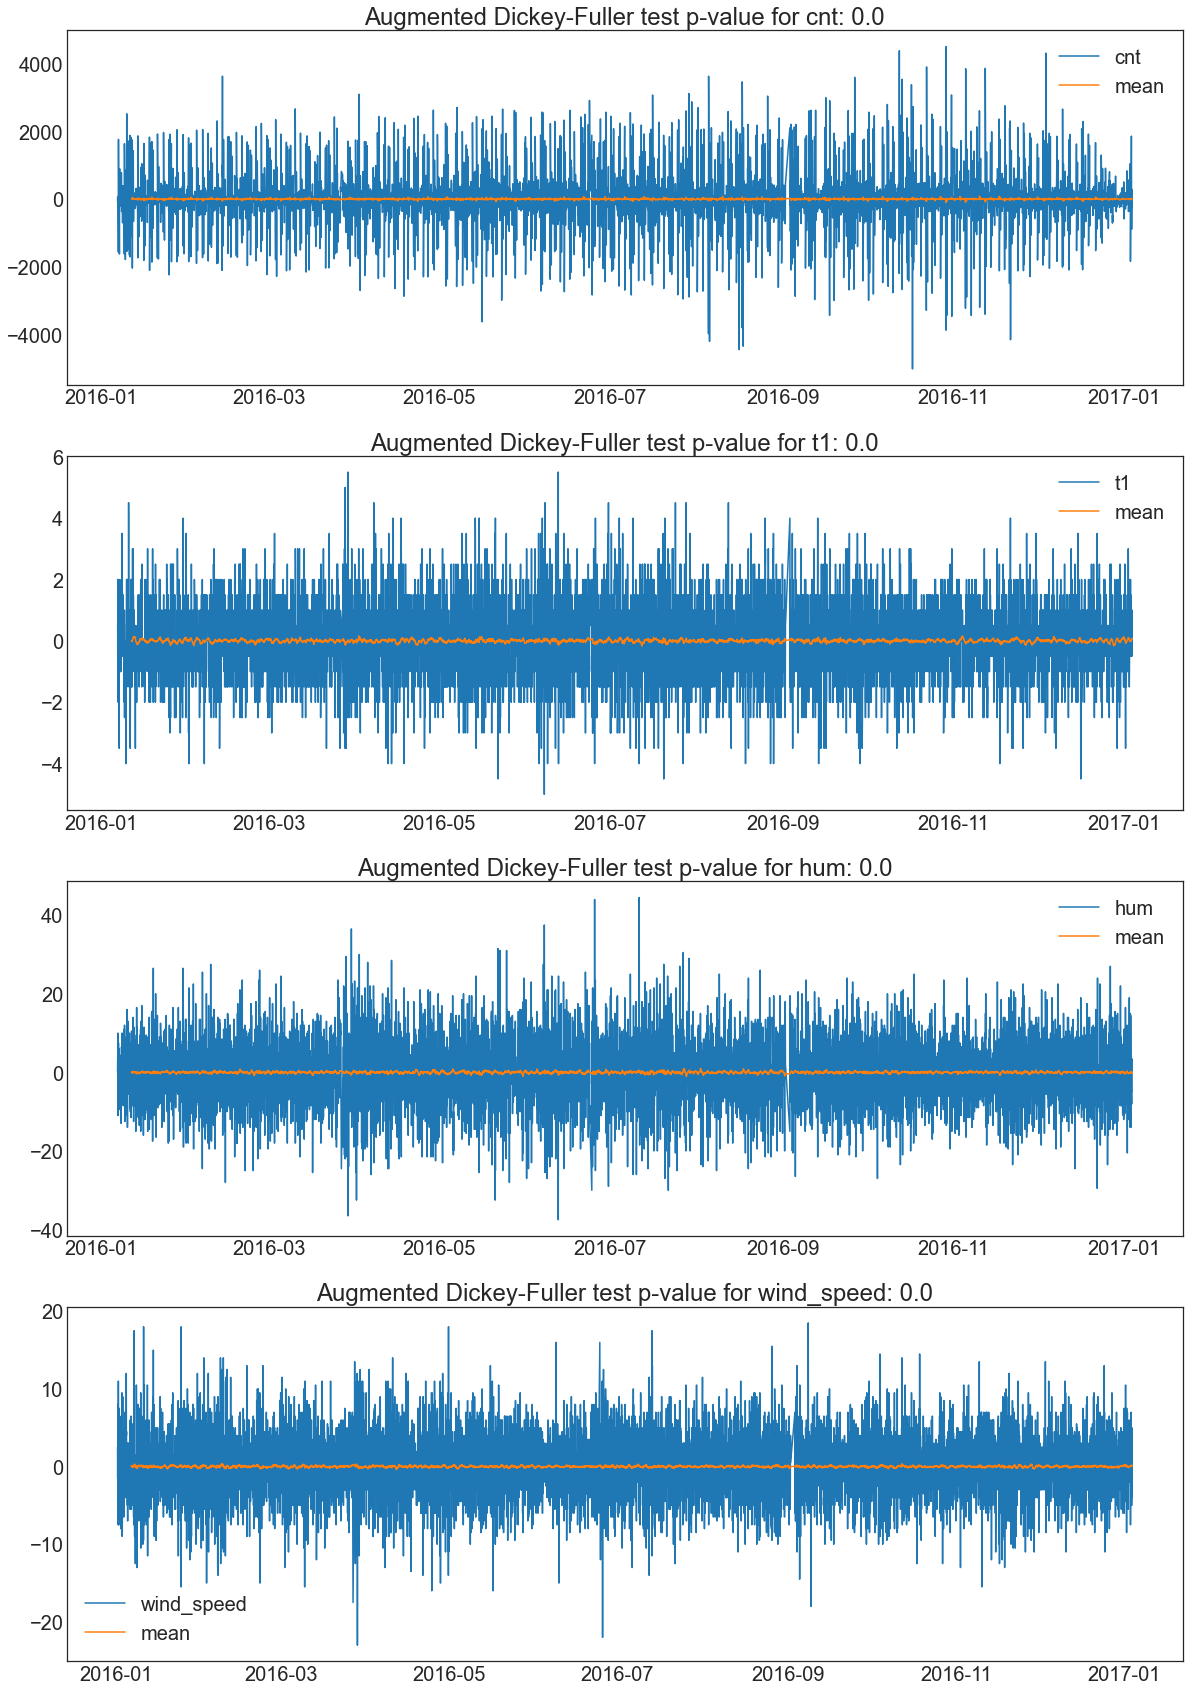

In [702]:
_, axes = plt.subplots(nrows=len(chosen_vars), figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    plot_series(chosen_vars[i], ax=ax)

In [703]:
def plot_acovf(series, ax1, ax2, nlag=100):
    ax1.plot(smt.stattools.acovf(series), label=series.name)
    ax2.plot(smt.stattools.acovf(series, nlag=nlag), label=series.name)
    for x in range(24, nlag, 24):
        ax2.axvline(x, c='r', alpha=0.3)
    ax1.legend()
    ax2.legend()

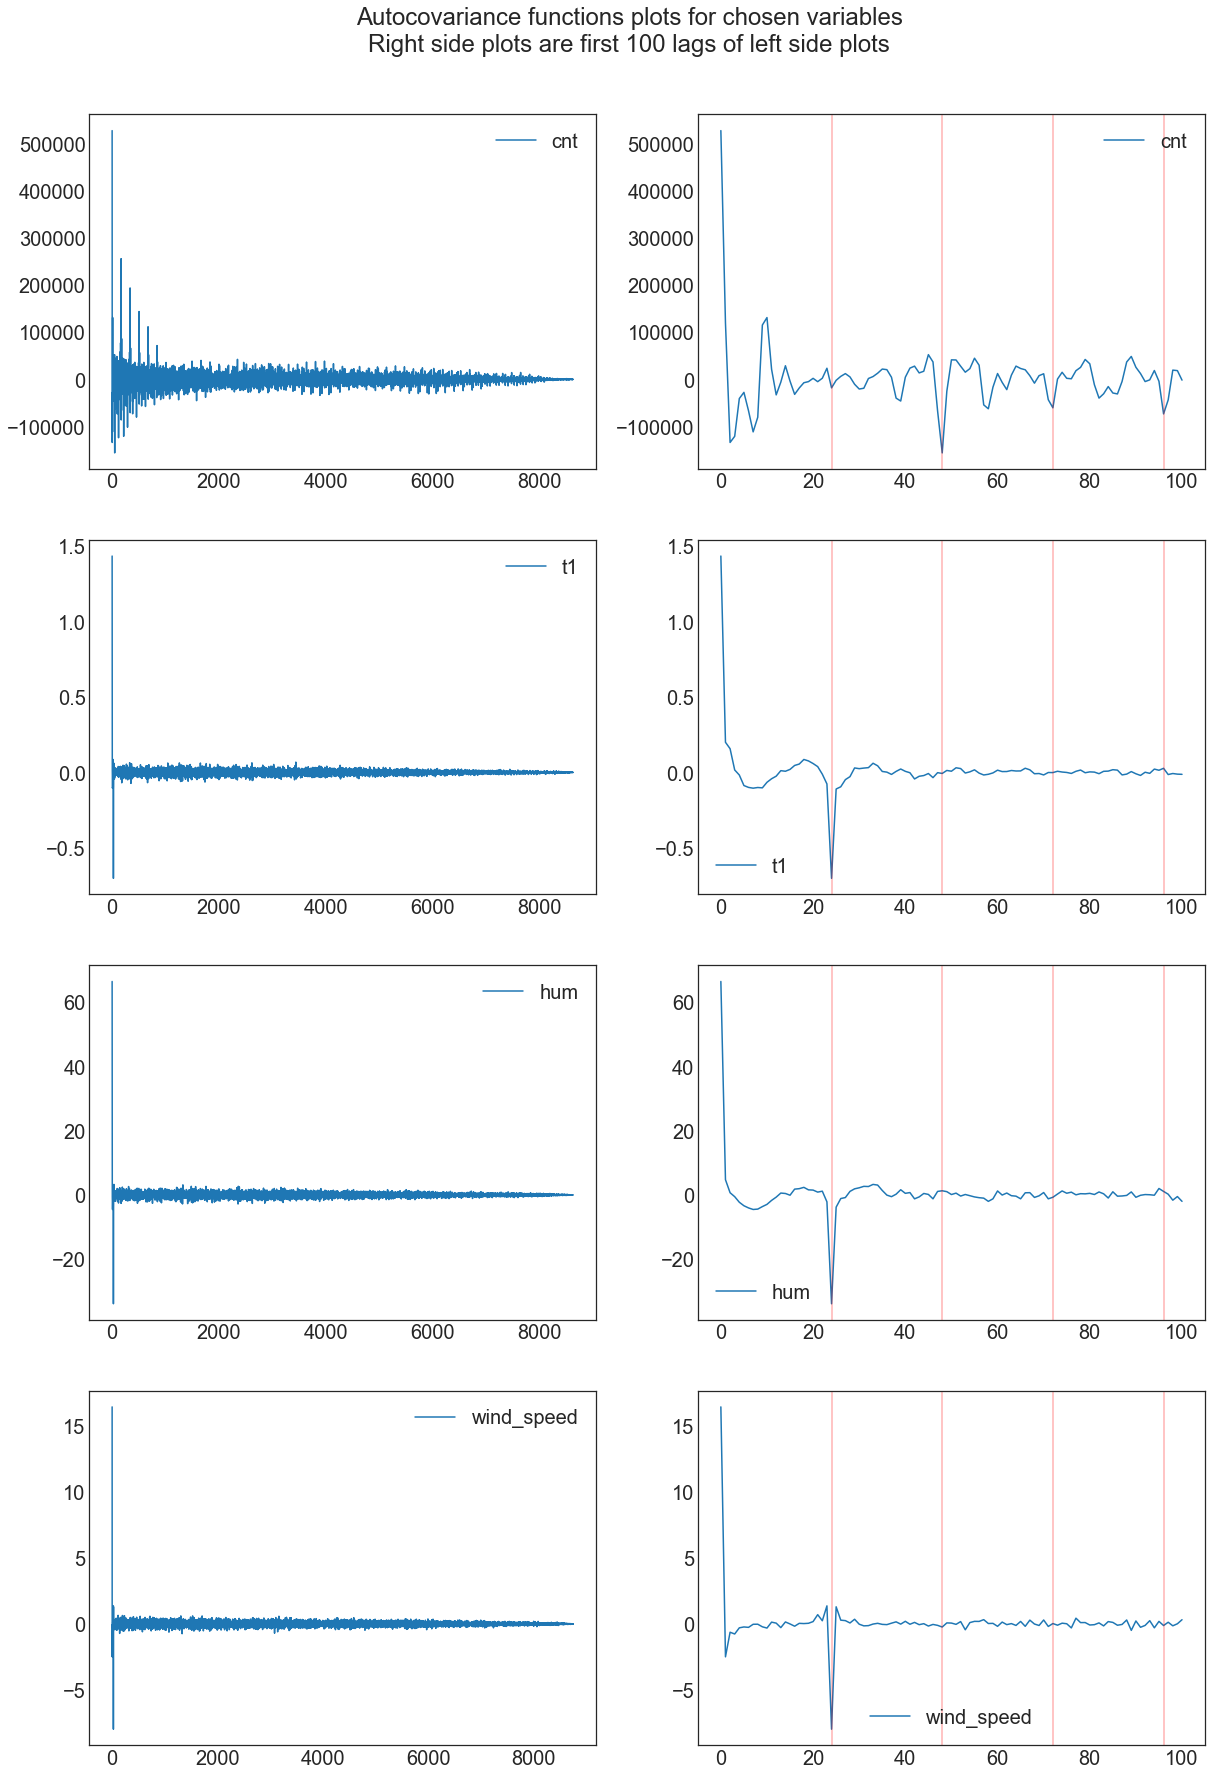

In [704]:
nlag = 100
_, axes = plt.subplots(nrows=len(chosen_vars), ncols=2, figsize=(20, 30))
plt.suptitle("Autocovariance functions plots for chosen variables\n"
             f"Right side plots are first {nlag} lags of left side plots", y=0.93)
for i, ax_row in enumerate(axes):
    plot_acovf(chosen_vars[i], ax1=ax_row[0], ax2=ax_row[1], nlag=nlag)

Analysis of the plots shows that all chosen variables are stationary.

In [705]:
def plot_target_filtered(series, ax):
    ax.plot(series, label='True series')
    ax.plot(filter1(series), label='First filtered series')
    ax.plot(filter2(series), label='Second filtered series')
    ax.title.set_text(series.name)
    ax.legend()

In [706]:
filter1 = lambda x: x.rolling(
    window=24, win_type='gaussian', min_periods=1, center=True).mean(std=1)
filter2 = lambda x: x.rolling(
    window=12, win_type='hamming', min_periods=1, center=True).mean()

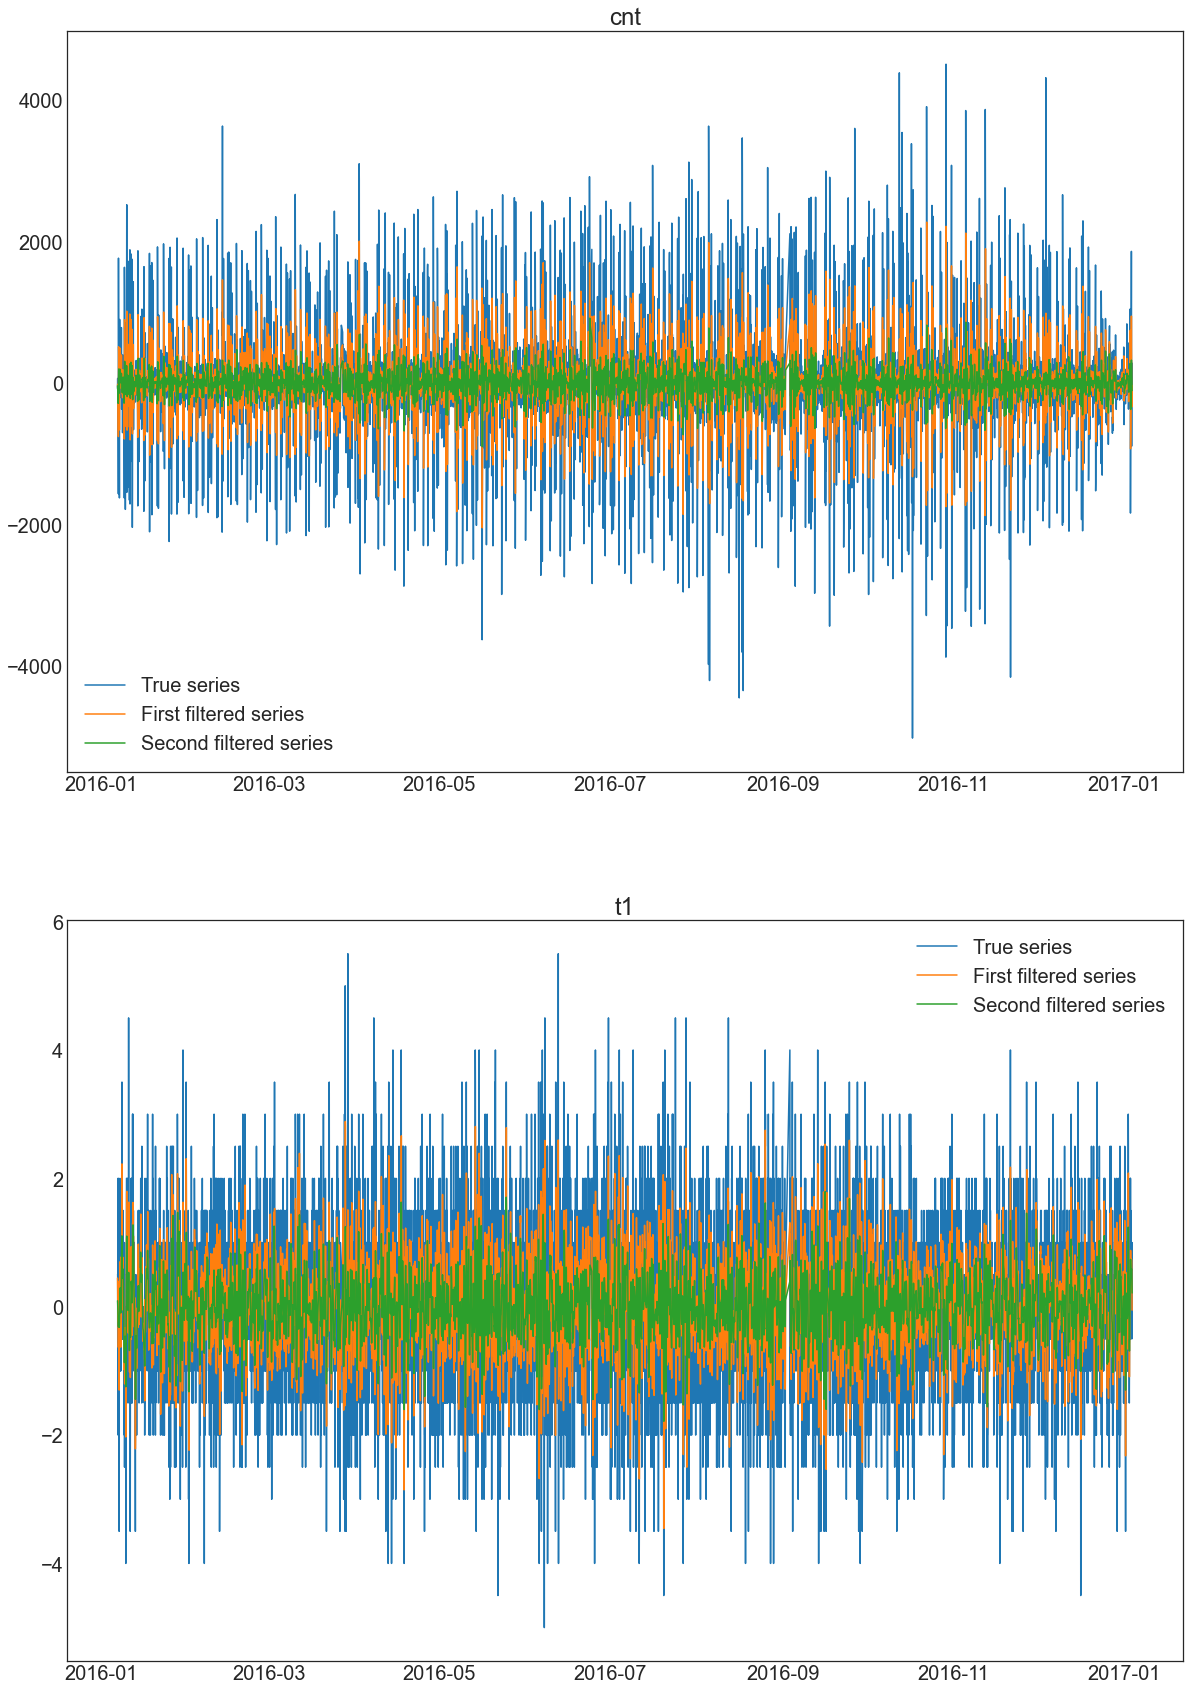

In [707]:
_, axes = plt.subplots(nrows=len(targets), figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    plot_target_filtered(targets[i], ax=ax)

In [708]:
def plot_sdf(series, ax):
    f, pxx = signal.welch(series, nfft=1000, nperseg=200, scaling='spectrum')
    f_filt1, pxx_filt1 = signal.welch(filter1(series).dropna(), nfft=1000, nperseg=100, scaling='spectrum')
    f_filt2, pxx_filt2 = signal.welch(filter2(series).dropna(), nfft=1000, nperseg=100, scaling='spectrum')
    ax.plot(f, pxx, linewidth=3, label='True series')
    ax.plot(f_filt1, pxx_filt1, label='First filtered series')
    ax.plot(f_filt2, pxx_filt2, label='Second filtered series')
    ax.title.set_text(series.name)
    ax.legend()

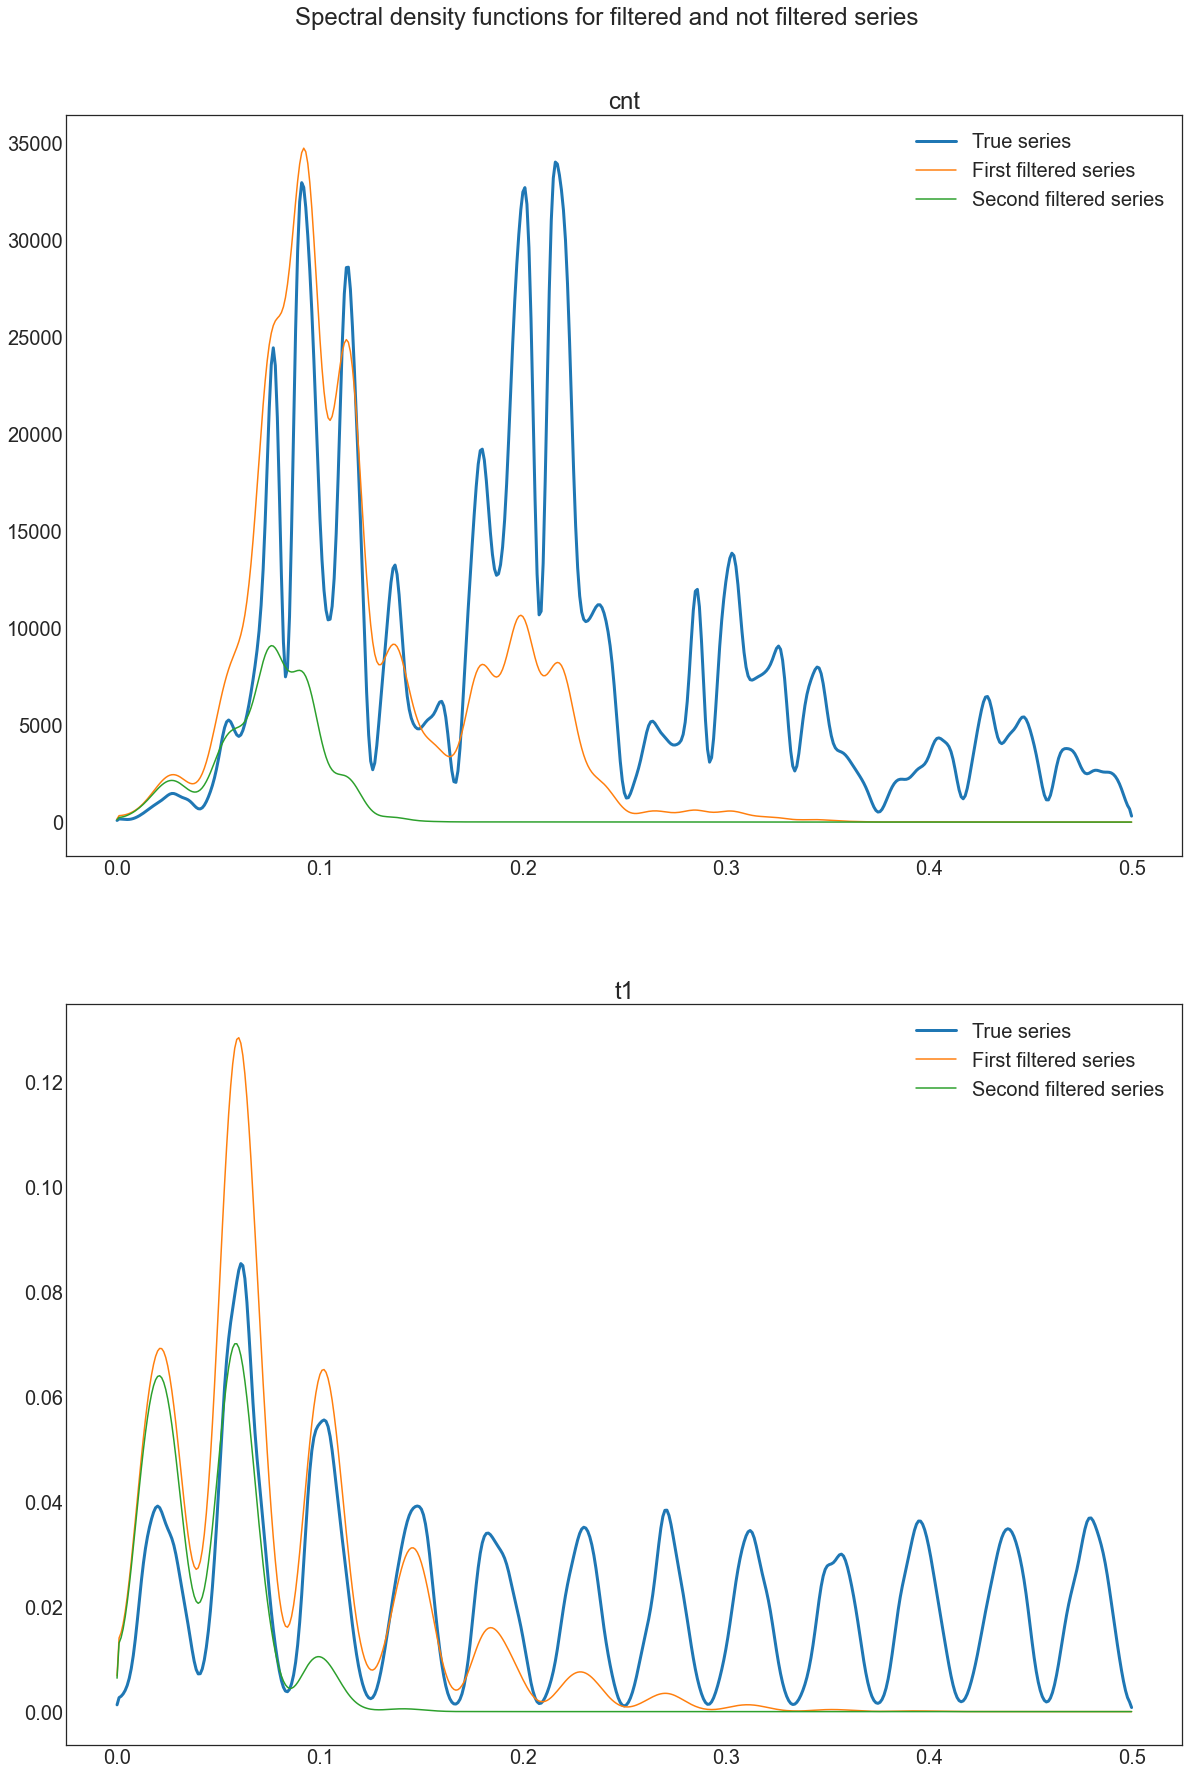

In [709]:
# Estimating spectral density function for with and without filtering
_, axes = plt.subplots(nrows=len(targets), figsize=(20, 30))
plt.suptitle("Spectral density functions for filtered and not filtered series", y=0.93)
for i, ax in enumerate(axes.flatten()):
    plot_sdf(targets[i], ax=ax)

In [772]:
series = targets[0].dropna().copy()
series_train, series_test = train_test_split(
    series, train_size=500, shuffle=False, random_state=42
)
ps = range(0, 8)
qs = range(0, 8)
parameters = product(ps, qs)
parameters_list = list(parameters)
print (u"Models to analyse by MAE:", len(parameters_list))

Models to analyse by MAE: 64


In [773]:
# finding and fitting best ARMA model for not filtered t1 series 
results = []
best_err = np.inf
for param in tqdm(parameters_list):
    #try except for the case of wrong parameters
    try:
        model = smt.ARIMA(series_train, order=(param[0], 0, param[1])).fit()
    except ValueError:
            continue
    error = np.abs(model.forecasts_error).sum()

    # save best model, error, parameters
    if (error < best_err):
        best_model = model
        best_err = error
        best_param = param
    results.append([param, error])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'error']
print(result_table.sort_values(by = 'error', ascending=True).head())

  0%|          | 0/64 [00:00<?, ?it/s]

   parameters          error
63     (7, 7)  150967.210535
62     (7, 6)  151057.367649
53     (6, 5)  151832.543925
61     (7, 5)  152394.390317
39     (4, 7)  153441.554100


In [774]:
# finding and fitting best ARMA model for filtered t1 series 
series_train, series_test = train_test_split(
    filter2(series).dropna(), train_size=500, shuffle=False, random_state=42
)
results = []
best_err = np.inf
for param in tqdm(parameters_list):
    #try except for the case of wrong parameters
    try:
        model = smt.ARIMA(series_train, order=(param[0], 0, param[1]),).fit()
    except ValueError:
            continue
    error = np.abs(model.forecasts_error).sum()

    # save best model, error, parameters
    if (error < best_err):
        best_model_filt = model
        best_err = error
        best_param = param
    results.append([param, error])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'error']
print(result_table.sort_values(by = 'error', ascending=True).head())

  0%|          | 0/64 [00:00<?, ?it/s]

   parameters        error
62     (7, 6)  4744.717627
46     (5, 6)  4799.609701
63     (7, 7)  4855.490805
55     (6, 7)  4863.592460
54     (6, 6)  4877.249079


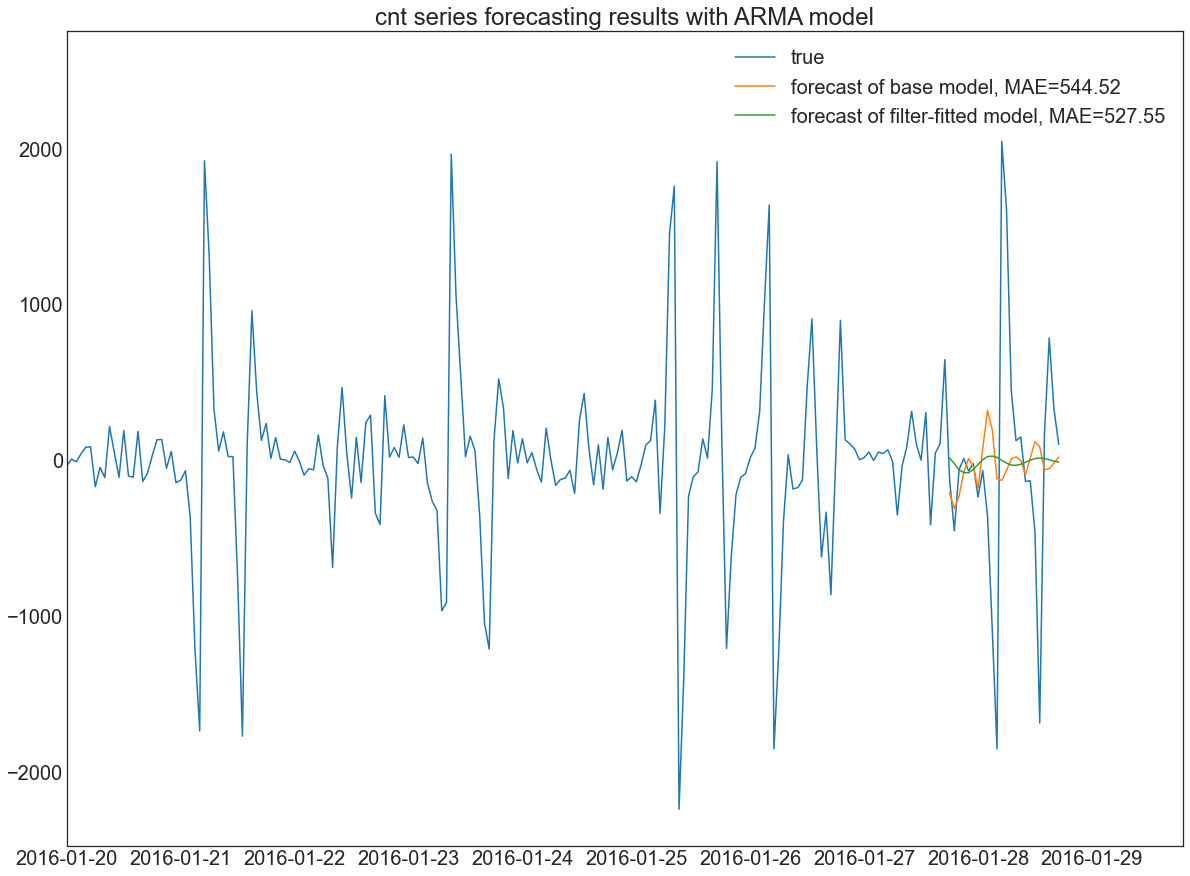

In [775]:
forecast_len = 24
pred = best_model.forecast(forecast_len)
pred_filt = best_model_filt.forecast(forecast_len)
plt.figure(figsize=(20, 15))
plt.title(series.name + " series forecasting results with ARMA model")
plt.plot(series.iloc[:len(series_train) + forecast_len], label='true')
plt.plot(pred, label=f'forecast of base model, MAE={round(mae(series.loc[pred.index], pred), 2)}')
plt.plot(pred_filt, label=f'forecast of filter-fitted model, MAE={round(mae(series.loc[pred_filt.index], pred_filt), 2)}')
plt.xlim(dt.datetime(2016, 1, 20, 0))
plt.legend()

In [776]:
# finding and fitting best ARMAX model for not filtered t1 series 
series = targets[0].dropna().copy()
exog = pd.DataFrame(chosen_vars[1:]).T.dropna()
series_train, series_test, exog_train, exog_test = train_test_split(
    series, exog, train_size=500, shuffle=False, random_state=42
)

results = []
best_err = np.inf
for param in tqdm(parameters_list):
    #try except for the case of wrong parameters
    try:
        model = smt.ARIMA(series_train, exog=exog_train, order=(param[0], 0, param[1])).fit()
    except ValueError:
            continue
    error = np.abs(model.forecasts_error).sum()

    # save best model, error, parameters
    if (error < best_err):
        best_model = model
        best_err = error
        best_param = param
    results.append([param, error])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'error']
print(result_table.sort_values(by = 'error', ascending=True).head())

  0%|          | 0/64 [00:00<?, ?it/s]

   parameters          error
62     (7, 6)  150459.787598
63     (7, 7)  150932.732838
53     (6, 5)  151367.840009
61     (7, 5)  151854.856701
39     (4, 7)  152999.175255


In [777]:
# finding and fitting best ARMAX model for filtered t1 series 
series_train, series_test, exog_train, exog_test = train_test_split(
    filter2(series), exog, train_size=500, shuffle=False, random_state=42
)
results = []
best_err = np.inf
for param in tqdm(parameters_list):
    #try except for the case of wrong parameters
    try:
        model = smt.ARIMA(series_train, exog=exog_train, order=(param[0], 0, param[1]),).fit()
    except:
        continue
    error = np.abs(model.forecasts_error).sum()

    # save best model, error, parameters
    if (error < best_err):
        best_model_filt = model
        best_err = error
        best_param = param
    results.append([param, error])
    
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'error']
print(result_table.sort_values(by = 'error', ascending=True).head())

  0%|          | 0/64 [00:00<?, ?it/s]

   parameters        error
62     (7, 7)  4975.879510
39     (4, 7)  4979.563922
38     (4, 6)  5027.239308
61     (7, 6)  5090.877360
37     (4, 5)  5094.440335


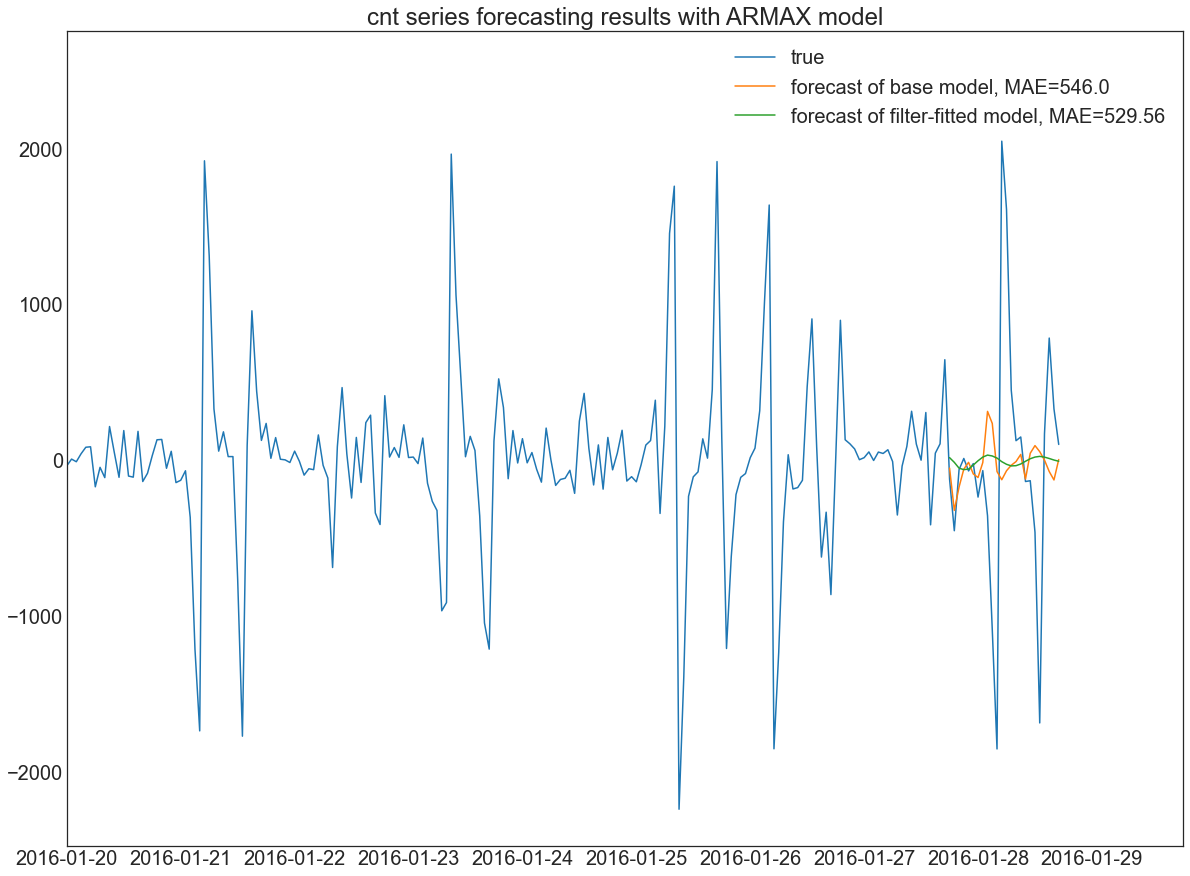

In [778]:
forecast_len = 24
pred = best_model.forecast(forecast_len, exog=exog_test.iloc[:forecast_len])
pred_filt = best_model_filt.forecast(forecast_len, exog=exog_test.iloc[:forecast_len])
plt.figure(figsize=(20, 15))
plt.title(series.name + " series forecasting results with ARMAX model")
plt.plot(series.iloc[:len(series_train) + forecast_len], label='true')
plt.plot(pred, label=f'forecast of base model, MAE={round(mae(series.loc[pred.index], pred), 2)}')
plt.plot(pred_filt, label=f'forecast of filter-fitted model, MAE={round(mae(series.loc[pred_filt.index], pred_filt), 2)}')
plt.xlim(dt.datetime(2016, 1, 20, 0))
plt.legend()